**Общая информация**

**Срок сдачи:** 20 марта 2019, 06:00 <br\>
**Штраф за опоздание:** -1 балл после 06:00 20 марта, -2 балла после 06:00 27 марта, -3 балла после 06:00 3 апреля
-4 балла после 06:00 10 апреля

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack скинуть ссылку в личный чат @alkhamush
Пример ссылки:
https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -0.5 баллов


In [15]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_openml
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
#%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle
# Закомментированные magics не работают(не устанавливаются необходимые зависимости)
class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        pass
    
    def fit(self, X, y):
        if(self.algorithm == 'brute'):
            self.X = X.copy()
        if(self.algorithm == 'kd_tree'):
            from sklearn.neighbors import KDTree
            self.X = KDTree(X)
        self.Y = y.copy()
        self.Y_numb = np.asarray(self.Y, dtype = np.uint32) 
        self.n_class = np.unique(self.Y).shape[0]
        return self.fit
    
    def predict(self, X):
        if self.algorithm == 'brute':
            from sklearn.metrics import pairwise_distances_chunked
            def my_reduce_func(chank, start):
                return self.Y[np.argpartition(chank, self.n_neighbors, axis = 1)[:,:self.n_neighbors]]
            tmp = pairwise_distances_chunked(X, self.X, reduce_func = my_reduce_func)
            return np.asarray([np.unique(i)[np.argmax(np.unique(i, return_counts = True)[1])]
                               for i in list(tmp)[0]])
        
        if self.algorithm == 'kd_tree':
            tmp = self.Y[self.X.query(X, k = self.n_neighbors, return_distance = False)]
        return np.asarray([np.unique(i)[np.argmax(np.unique(i, return_counts = True)[1])] for i in tmp])
        
    def predict_proba(self, X):
        if(self.algorithm == 'brute'):
            from sklearn.metrics import pairwise_distances_chunked
            def my_reduce_func(chank, start):
                return self.Y_numb[np.argpartition(chank,
                                                   self.n_neighbors, axis = 1)[:,:self.n_neighbors]]
            tmp = pairwise_distances_chunked(X, self.X, reduce_func = my_reduce_func)
            tmp = np.apply_along_axis(np.bincount, 1, list(tmp)[0], minlength = self.n_class)
        if(self.algorithm == 'kd_tree'):
            tmp = self.Y_numb[self.X.query(X, k = self.n_neighbors, return_distance = False)]
            tmp = np.apply_along_axis(np.bincount, 1, tmp, minlength = self.n_class)
        return tmp / np.sum(tmp, axis = 1).reshape((tmp.shape[0],1))
    
    def score(self, X, y):
        tmp = self.predict(X) == y
        return np.sum(tmp)/tmp.shape[0]

**IRIS**

In [37]:
iris = datasets.load_iris()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
%time clf.fit(X_train, y_train)

Wall time: 1.22 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [7]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


<bound method MyKNeighborsClassifier.fit of MyKNeighborsClassifier(algorithm='brute', n_neighbors=2)>

In [8]:
%time clf.predict(X_test)

Wall time: 20.4 ms


array([0, 2, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 2, 1, 1])

In [9]:
%time my_clf.predict(X_test)

Wall time: 6.61 ms


array([0, 2, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 2, 1, 1])

In [10]:
%time clf.predict_proba(X_test)

Wall time: 0 ns


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [11]:
%time my_clf.predict_proba(X_test)

Wall time: 997 µs


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [12]:
clf.score(X_test, y_test)

1.0

In [13]:
my_clf.score(X_test, y_test)

1.0

Задание 3

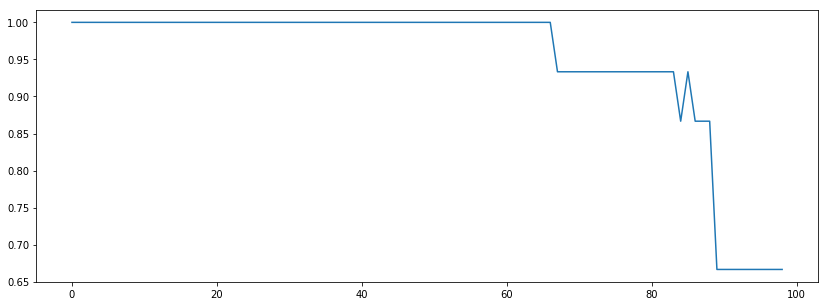

In [41]:
y = []
for i in range(1, 100):
    my_clf = MyKNeighborsClassifier(n_neighbors=i)
    my_clf.fit(X_train, y_train)
    y.append(my_clf.score(X_test, y_test))
plt.figure(figsize=(14,5))
plt.plot(y);

**MNIST**

In [16]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target,
                                                    test_size=0.01, stratify=mnist.target)

In [18]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [19]:
%time clf.fit(X_train, y_train)

Wall time: 409 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [20]:
%time my_clf.fit(X_train, y_train)

Wall time: 238 ms


<bound method MyKNeighborsClassifier.fit of MyKNeighborsClassifier(algorithm='brute', n_neighbors=2)>

In [21]:
%time clf.predict(X_test)

Wall time: 3.16 s


array(['8', '3', '0', '4', '7', '6', '3', '7', '0', '6', '5', '7', '3',
       '9', '9', '6', '6', '7', '5', '6', '3', '5', '0', '4', '0', '1',
       '2', '8', '5', '5', '1', '2', '3', '5', '5', '0', '4', '0', '1',
       '4', '6', '3', '2', '4', '2', '6', '8', '5', '4', '6', '8', '3',
       '1', '1', '9', '5', '2', '5', '3', '6', '7', '2', '5', '4', '4',
       '2', '7', '7', '6', '6', '1', '3', '1', '3', '1', '9', '8', '3',
       '9', '8', '1', '3', '9', '9', '7', '5', '1', '0', '7', '5', '9',
       '3', '5', '2', '2', '1', '3', '8', '8', '2', '1', '4', '3', '1',
       '9', '7', '6', '4', '3', '7', '2', '5', '1', '4', '7', '1', '1',
       '3', '4', '8', '1', '3', '3', '0', '3', '8', '0', '7', '6', '0',
       '5', '8', '4', '3', '9', '3', '1', '7', '3', '1', '4', '0', '0',
       '4', '6', '7', '6', '2', '5', '9', '0', '9', '7', '7', '0', '6',
       '1', '5', '9', '0', '0', '8', '0', '0', '2', '6', '1', '8', '7',
       '1', '0', '7', '7', '0', '0', '2', '1', '6', '6', '1', '6

In [22]:
%time my_clf.predict(X_test)

Wall time: 3.27 s


array(['8', '3', '0', '4', '7', '6', '3', '7', '0', '6', '5', '7', '3',
       '9', '9', '6', '6', '7', '5', '6', '3', '5', '0', '4', '0', '1',
       '2', '8', '5', '5', '1', '2', '3', '5', '5', '0', '4', '0', '1',
       '4', '6', '3', '2', '4', '2', '6', '8', '5', '4', '6', '8', '3',
       '1', '1', '9', '5', '2', '5', '3', '6', '7', '2', '5', '4', '4',
       '2', '7', '7', '6', '6', '1', '3', '1', '3', '1', '9', '8', '3',
       '9', '8', '1', '3', '9', '9', '7', '5', '1', '0', '7', '5', '9',
       '3', '5', '2', '2', '1', '3', '8', '8', '2', '1', '4', '3', '1',
       '9', '7', '6', '4', '3', '7', '2', '5', '1', '4', '7', '1', '1',
       '3', '4', '8', '1', '3', '3', '0', '3', '8', '0', '7', '6', '0',
       '5', '8', '4', '3', '9', '3', '1', '7', '3', '1', '4', '0', '0',
       '4', '6', '7', '6', '2', '5', '9', '0', '9', '7', '7', '0', '6',
       '1', '5', '9', '0', '0', '8', '0', '0', '2', '6', '1', '8', '7',
       '1', '0', '7', '7', '0', '0', '2', '1', '6', '6', '1', '6

In [23]:
%time clf.predict_proba(X_test)

Wall time: 3 s


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [24]:
%time my_clf.predict_proba(X_test)

Wall time: 3.21 s


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [25]:
clf.score(X_test, y_test)

0.9714285714285714

In [26]:
my_clf.score(X_test, y_test)

0.9714285714285714

Задание 4

In [27]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target,
                                                    test_size=0.01, stratify = mnist.target)

In [29]:
%time clf.fit(X_train, y_train)

Wall time: 51.7 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [30]:
%time my_clf.fit(X_train, y_train)

Wall time: 50.7 s


<bound method MyKNeighborsClassifier.fit of MyKNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)>

In [31]:
%time clf.predict(X_test)

Wall time: 2min 40s


array(['7', '7', '3', '4', '9', '0', '2', '5', '8', '0', '1', '9', '1',
       '4', '2', '1', '2', '8', '3', '2', '2', '7', '8', '3', '5', '9',
       '7', '3', '4', '5', '0', '3', '9', '0', '4', '4', '2', '7', '0',
       '5', '0', '8', '9', '9', '7', '1', '0', '6', '1', '3', '2', '6',
       '3', '0', '0', '3', '3', '4', '6', '1', '2', '6', '6', '0', '9',
       '0', '7', '9', '0', '3', '2', '1', '2', '4', '4', '4', '9', '8',
       '3', '0', '0', '2', '2', '7', '3', '4', '9', '0', '0', '9', '6',
       '9', '8', '9', '3', '4', '3', '9', '2', '3', '9', '2', '6', '7',
       '3', '9', '4', '8', '5', '9', '1', '5', '6', '6', '0', '4', '8',
       '0', '7', '6', '8', '4', '6', '1', '1', '0', '5', '1', '3', '6',
       '5', '5', '1', '9', '0', '0', '2', '4', '5', '6', '0', '9', '8',
       '0', '7', '9', '6', '9', '6', '7', '1', '7', '4', '3', '2', '6',
       '3', '8', '8', '2', '0', '5', '1', '8', '0', '1', '9', '0', '7',
       '3', '2', '7', '2', '8', '8', '6', '6', '1', '2', '3', '2

In [32]:
%time my_clf.predict(X_test)

Wall time: 2min 12s


array(['7', '7', '3', '4', '9', '0', '2', '5', '8', '0', '1', '9', '1',
       '4', '2', '1', '2', '8', '3', '2', '2', '7', '8', '3', '5', '9',
       '7', '3', '4', '5', '0', '3', '9', '0', '4', '4', '2', '7', '0',
       '5', '0', '8', '9', '9', '7', '1', '0', '6', '1', '3', '2', '6',
       '3', '0', '0', '3', '3', '4', '6', '1', '2', '6', '6', '0', '9',
       '0', '7', '9', '0', '3', '2', '1', '2', '4', '4', '4', '9', '8',
       '3', '0', '0', '2', '2', '7', '3', '4', '9', '0', '0', '9', '6',
       '9', '8', '9', '3', '4', '3', '9', '2', '3', '9', '2', '6', '7',
       '3', '9', '4', '8', '5', '9', '1', '5', '6', '6', '0', '4', '8',
       '0', '7', '6', '8', '4', '6', '1', '1', '0', '5', '1', '3', '6',
       '5', '5', '1', '9', '0', '0', '2', '4', '5', '6', '0', '9', '8',
       '0', '7', '9', '6', '9', '6', '7', '1', '7', '4', '3', '2', '6',
       '3', '8', '8', '2', '0', '5', '1', '8', '0', '1', '9', '0', '7',
       '3', '2', '7', '2', '8', '8', '6', '6', '1', '2', '3', '2

In [33]:
%time clf.predict_proba(X_test)

Wall time: 1min 41s


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [34]:
%time my_clf.predict_proba(X_test)

Wall time: 58.1 s


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [35]:
clf.score(X_test, y_test)

0.97

In [36]:
my_clf.score(X_test, y_test)

0.97

Задание 5

In [ ]:
 #seaborn - визуализация данных
 #matplotlib - визуализация данных
 #train_test_split - разделение датасета на train & test 
 #Pipelin%load_ext e (from sklearn.pipeline import Pipeline) - создание цепи последовательных преобразований
 #StandardScaler (from sklearn.preprocessing import StandardScaler) -
 #     -преобразование z = (x - u) / s, u - среднее x, s - дисперсия x
 #ClassifierMixin - Mixin class for all classifiers in scikit-learn.
 #NeighborsBase - Base class for nearest neighbors estimators
 #KNeighborsMixin - Mixin for k-neighbors searches
 #SupervisedIntegerMixin -
 #      - содержит метод fit  который валидирует данные и ,при необходимости(и возможности),
 #        приводит их к нужному формату, затем вызывает метод _fit